## Model Inference Test

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.abspath(''), '../'))

from misc.Notebooks import setup_one_gpu
setup_one_gpu()

import peewee as pw
from toyDb.databases import ExperimentDb

import numpy as np
import json
import hashlib

from misc.Directory import (
  getIntermediateDir,
  getVkPredictRootDir
)
from dataset.FragmentPerformanceTracedSnapshotDataset import FragmentPerformanceTracedSnapshotDataset
from dataset.DatasetBuilder import build_dataset
from dataset.MapDataset import MapDataset
from model.ModelBuilder import build_model
from misc.TokenizerBuilder import build_tokenizer
from misc.normalization import (
    LogNormalizer,
    DummyNormalizer
)
from train import (
    TracedDatasetPostProcessor,
    DataCollatorWithPaddingAndTraceEmbedding
)
from misc.metric import compute_metrics
from typing import Union
from collections.abc import Mapping
import torch
import tqdm
import matplotlib.pyplot as plt
from toyDb.utils.spv.SpvContext import getDefaultGrammar
from compete.TracedPerInstLinearRegression import TracedPerInstLinearRegression

ExperimentDb.init_from_default_db()

Picking GPU 0


/home/lzt/Projects/NGPP/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-12-08 16:33:51,855] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
trainDataset = build_dataset("FragPerfSnapshotTracedDataset4096-6600xt-train", "train")
testDataset = build_dataset("FragPerfSnapshotTracedDataset4096-6600xt-train", "test")

In [27]:
TARGET_MODEL = "perfformer-layer9-regression-trace-input-embedding-xformers-memeff"
MODEL_LOAD_DIR = os.path.join(
    getVkPredictRootDir(), "Perfformer-NoRope-Trace-Onehot-Base2-Regression-lr1e-4-6600xt-log-time_HfTracedSpvTokenizer-multiple-entrypoint_perfformer-layer9-regression-trace-input-embedding-xformers-memeff/"
)

tokenizer = build_tokenizer("HfTracedSpvTokenizer-multiple-entrypoint")
model = build_model(
    TARGET_MODEL, "mse", 4096,
    tokenizer.bos_token_id, tokenizer.eos_token_id, tokenizer.pad_token_id,
    MODEL_LOAD_DIR
)

print(model)

PerfformerForRegression(
  (perfformer): PerfformerModel(
    (embeddings): PerfformerEmbeddings(
      (word_embeddings): Embedding(40000, 768, padding_idx=1000)
      (position_embeddings): Embedding(4096, 768, padding_idx=1000)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): PerfformerEncoder(
      (layer): ModuleList(
        (0-8): 9 x PerfformerLayer(
          (attention): PerfformerAttention(
            (self): PerfformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): PerfformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps

In [4]:
def atleast_1d(tensor_or_array: Union[torch.Tensor, np.ndarray]):
    if isinstance(tensor_or_array, torch.Tensor):
        if hasattr(torch, "atleast_1d"):
            tensor_or_array = torch.atleast_1d(tensor_or_array)
        elif tensor_or_array.ndim < 1:
            tensor_or_array = tensor_or_array[None]
    else:
        tensor_or_array = np.atleast_1d(tensor_or_array)
    return tensor_or_array

def torch_pad_and_concatenate(tensor1, tensor2, padding_index=-100):
    """Concatenates `tensor1` and `tensor2` on first axis, applying padding on the second if necessary."""
    tensor1 = atleast_1d(tensor1)
    tensor2 = atleast_1d(tensor2)

    if len(tensor1.shape) == 1 or tensor1.shape[1] == tensor2.shape[1]:
        return torch.cat((tensor1, tensor2), dim=0)

    # Let's figure out the new shape
    new_shape = (tensor1.shape[0] + tensor2.shape[0], max(tensor1.shape[1], tensor2.shape[1])) + tensor1.shape[2:]

    # Now let's fill the result tensor
    result = tensor1.new_full(new_shape, padding_index)
    result[: tensor1.shape[0], : tensor1.shape[1]] = tensor1
    result[tensor1.shape[0] :, : tensor2.shape[1]] = tensor2
    return result


def numpy_pad_and_concatenate(array1, array2, padding_index=-100):
    """Concatenates `array1` and `array2` on first axis, applying padding on the second if necessary."""
    array1 = atleast_1d(array1)
    array2 = atleast_1d(array2)

    if len(array1.shape) == 1 or array1.shape[1] == array2.shape[1]:
        return np.concatenate((array1, array2), axis=0)

    # Let's figure out the new shape
    new_shape = (array1.shape[0] + array2.shape[0], max(array1.shape[1], array2.shape[1])) + array1.shape[2:]

    # Now let's fill the result tensor
    result = np.full_like(array1, padding_index, shape=new_shape)
    result[: array1.shape[0], : array1.shape[1]] = array1
    result[array1.shape[0] :, : array2.shape[1]] = array2
    return result


def nested_concat(tensors, new_tensors, padding_index=-100):
    """
    Concat the `new_tensors` to `tensors` on the first dim and pad them on the second if needed. Works for tensors or
    nested list/tuples/dict of tensors.
    """
    assert type(tensors) == type(
        new_tensors
    ), f"Expected `tensors` and `new_tensors` to have the same type but found {type(tensors)} and {type(new_tensors)}."
    if isinstance(tensors, (list, tuple)):
        return type(tensors)(nested_concat(t, n, padding_index=padding_index) for t, n in zip(tensors, new_tensors))
    elif isinstance(tensors, torch.Tensor):
        return torch_pad_and_concatenate(tensors, new_tensors, padding_index=padding_index)
    elif isinstance(tensors, Mapping):
        return type(tensors)(
            {k: nested_concat(t, new_tensors[k], padding_index=padding_index) for k, t in tensors.items()}
        )
    elif isinstance(tensors, np.ndarray):
        return numpy_pad_and_concatenate(tensors, new_tensors, padding_index=padding_index)
    else:
        raise TypeError(f"Unsupported type for concatenation: got {type(tensors)}")


In [28]:
trainDatasetMapped = MapDataset(trainDataset, TracedDatasetPostProcessor, [tokenizer, LogNormalizer(), DummyNormalizer()])
testDatasetMapped = MapDataset(testDataset, TracedDatasetPostProcessor, [tokenizer, LogNormalizer(), DummyNormalizer()])

dataCollator = DataCollatorWithPaddingAndTraceEmbedding(
    tokenizer=tokenizer,
    trace_embedding_method="onehot-base2",
    trace_embedding_dim=model.config.hidden_size,
    padding='longest',
    pad_to_multiple_of=8
)

testLoader = torch.utils.data.DataLoader(
    testDatasetMapped,
    batch_size=4,
    shuffle=False,
    collate_fn=dataCollator
)

trainLoader = torch.utils.data.DataLoader(
    trainDatasetMapped,
    batch_size=4,
    shuffle=False,
    collate_fn=dataCollator
)

evalModelOnTestDataset = True
evalModelOnTrainDataset = True

if evalModelOnTestDataset:
    model.eval()

    INFERENCE_DEVICE = 'cuda'
    model.to(INFERENCE_DEVICE)

    labels = np.asarray([], dtype=np.float32)
    preds = np.asarray([], dtype=np.float32)

    with torch.no_grad():
        for model_inputs in tqdm.tqdm(testLoader):
            for k in model_inputs.keys():
                model_inputs[k] = model_inputs[k].to(INFERENCE_DEVICE)

            outputs = model(**model_inputs)
            labels = nested_concat(labels, model_inputs['labels'].cpu().numpy())
            preds = nested_concat(preds, outputs['logits'].squeeze(1).cpu().numpy())

    np.save("preds_6600xt.npy", preds)
    np.save("labels_6600xt.npy", labels)
else:
    preds = np.load("preds_6600xt.npy")
    labels = np.load("labels_6600xt.npy")

if evalModelOnTrainDataset:
    model.eval()

    INFERENCE_DEVICE = 'cuda'
    model.to(INFERENCE_DEVICE)

    labels_train = np.asarray([], dtype=np.float32)
    preds_train = np.asarray([], dtype=np.float32)

    with torch.no_grad():
        for model_inputs in tqdm.tqdm(trainLoader):
            for k in model_inputs.keys():
                model_inputs[k] = model_inputs[k].to(INFERENCE_DEVICE)

            outputs = model(**model_inputs)
            labels_train = nested_concat(labels_train, model_inputs['labels'].cpu().numpy())
            preds_train = nested_concat(preds_train, outputs['logits'].squeeze(1).cpu().numpy())

    np.save("preds_train_6600xt.npy", preds_train)
    np.save("labels_train_6600xt.npy", labels_train)
else:
    preds_train = np.load("preds_train_6600xt.npy")
    labels_train = np.load("labels_train_6600xt.npy")

100%|██████████| 2235/2235 [08:31<00:00,  4.37it/s]


In [29]:
shaderId_train = []
shaderId_test = []

for idx in tqdm.tqdm(range(len(trainDataset))):
  shaderId_train.append(trainDataset[idx]['shaderId'])

for idx in tqdm.tqdm(range(len(testDataset))):
  shaderId_test.append(testDataset[idx]['shaderId'])

100%|██████████| 2240/2240 [00:00<00:00, 40239.16it/s]


In [30]:
preds

array([ -9.983841, -10.004244, -10.03474 , ...,  -8.033187,  -8.139498,
        -9.174132], dtype=float32)

In [31]:
labels

array([-11.297384 , -11.0744295,  -9.863634 , ...,  -7.7983193,
        -8.111679 ,  -9.055868 ], dtype=float32)

In [32]:
preds_orig = LogNormalizer().invNormalize(preds)
labels_orig = LogNormalizer().invNormalize(labels)

In [33]:
preds_orig

array([4.61395066e-05, 4.52076638e-05, 4.38497955e-05, ...,
       3.24512366e-04, 2.91783712e-04, 1.03687154e-04], dtype=float32)

In [34]:
labels_orig

array([1.2405330e-05, 1.5503736e-05, 5.2032912e-05, ..., 4.1042414e-04,
       3.0001468e-04, 1.1670418e-04], dtype=float32)

In [35]:
compute_metrics(preds_orig, labels_orig)

/home/lzt/Projects/NGPP/vkPredict/notebooks/../misc/metric.py:39: RuntimeWarning: Mean of empty slice.
  ((candRealTime - candPredTime)**2).mean(axis=0)
/home/lzt/Projects/NGPP/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lzt/Projects/NGPP/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


{'mse_sqrt': 0.001835283,
 'mae': 0.00039935604,
 'mape': 0.633439,
 'mse_sqrt_ge_10000fps': 7.271823e-05,
 'mae_ge_10000fps': 3.3252378e-05,
 'mape_ge_10000fps': 0.92290497,
 'mse_sqrt_ge_1000_le_10000fps': 0.00024826208,
 'mae_ge_1000_le_10000fps': 0.00015109176,
 'mape_ge_1000_le_10000fps': 0.40887287,
 'mse_sqrt_ge_100_le_1000fps': 0.0017536561,
 'mae_ge_100_le_1000fps': 0.0010291265,
 'mape_ge_100_le_1000fps': 0.37667364,
 'mse_sqrt_ge_10_le_100fps': 0.014589414,
 'mae_ge_10_le_100fps': 0.012095051,
 'mape_ge_10_le_100fps': 0.6147925,
 'mse_sqrt_le_10fps': nan,
 'mae_le_10fps': nan,
 'mape_le_10fps': nan}

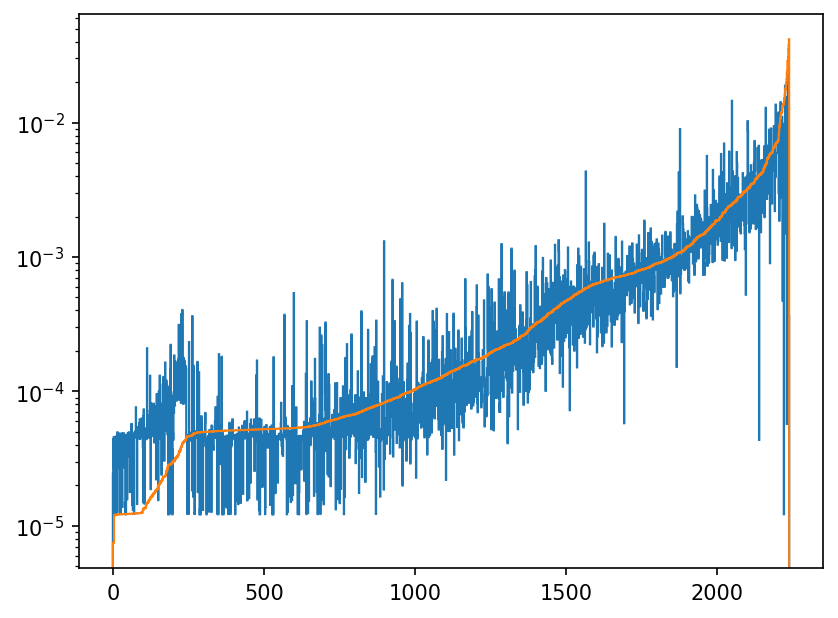

In [36]:
labelSortIndices = np.argsort(labels_orig)
predOrigSorted = preds_orig[labelSortIndices]
labelOrigSorted = labels_orig[labelSortIndices]

plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()

ax.set_yscale('log')
# axPred.set_xlabel('Ordinal by timeMean[0]')
# axStd.set_ylim(bottom=1e-10, top=1e-3)

ax.stairs(predOrigSorted)
ax.stairs(labelOrigSorted)

In [37]:
grammar = getDefaultGrammar()
regressor = TracedPerInstLinearRegression(grammar, True, True)
regressor.train(trainDataset)

print(f"- Model coef: {regressor.model.coef_}")
print(f"- Model intercept: {regressor.model.intercept_}")

Y_real, Y_pred = regressor.evaluate(testDataset)

Training:   0%|          | 0/8938 [00:00<?, ?it/s, id=3slGWS]

Training:  60%|██████    | 5378/8938 [01:08<00:49, 71.36it/s, id=ltsyWl] Basic block #12 not in traced block list. 
Basic block #73 not in traced block list. 
Basic block #77 not in traced block list. 
Basic block #74 not in traced block list. 
Basic block #76 not in traced block list. 
Basic block #75 not in traced block list. 
Training: 100%|██████████| 8938/8938 [01:50<00:00, 80.86it/s, id=sdGBRh] 


model coef_=[-1.94669925e-09 -4.22040536e-09 -1.30135486e-13 -1.17842749e-10
 -2.17653867e-10 -3.44138273e-10 -1.75871362e-13  2.41264018e-12
 -2.54250492e-11  1.99749158e-11 -1.56880984e-11  7.48265512e-12
  1.61744836e-11 -7.43547498e-12  1.77346159e-11 -6.19541701e-12
 -3.67497092e-12  6.44830326e-13 -3.29455213e-13 -1.72455973e-11
  8.80173972e-13 -1.62176999e-12 -6.80747646e-12 -5.43526422e-12
 -2.17155807e-12 -7.47916486e-13 -1.08029688e-12 -6.42657368e-12
  2.44553162e-12 -5.37303275e-13  4.48491981e-12 -8.00744020e-14
 -1.00159356e-12  9.72060106e-13  2.42320703e-12  4.70973954e-13
 -1.92443717e-13  1.36946747e-12 -9.57845348e-13 -1.40673063e-13
 -6.79550166e-13  6.07365720e-13  9.98747092e-13 -1.27204237e-13
  1.60670088e-14  3.99022829e-13  1.86963292e-13 -6.27858876e-13
  5.13738357e-14 -9.26880100e-14 -2.50901730e-13 -1.96453964e-13
 -2.36635364e-13 -3.35234444e-13  7.97151407e-13 -3.26284139e-14
 -1.50039703e-13 -6.76719965e-13  1.12108239e-13 -1.02574546e-12
  2.36546893e

Evaluation: 100%|██████████| 2240/2240 [00:25<00:00, 89.54it/s] 


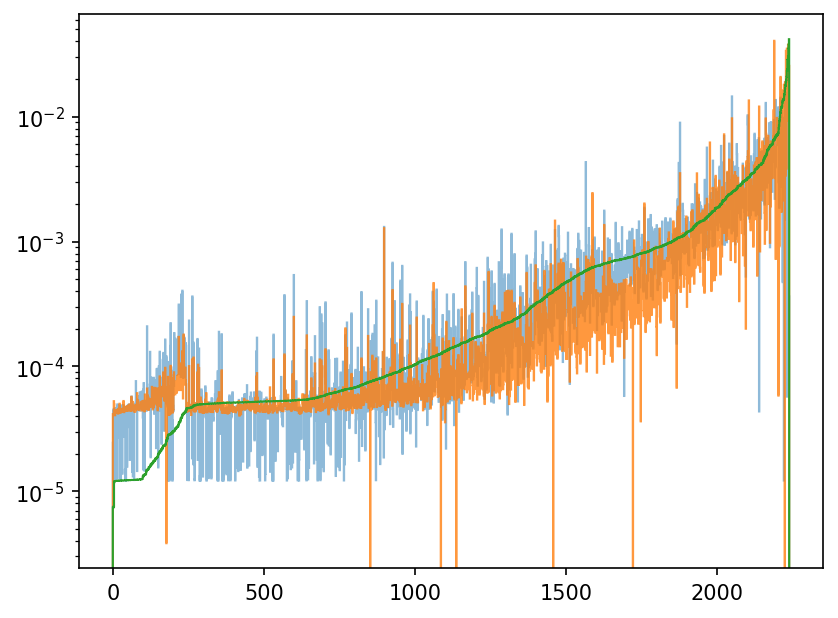

In [38]:
linRegPredsSorted = Y_pred[labelSortIndices]

plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()

ax.set_yscale('log')
# axPred.set_xlabel('Ordinal by timeMean[0]')
# axStd.set_ylim(bottom=1e-10, top=1e-3)

ax.stairs(predOrigSorted, alpha=0.5)
ax.stairs(linRegPredsSorted, alpha=0.8)
ax.stairs(labelOrigSorted)

In [39]:
np.mean(1.0 / labels_orig * (preds_orig - labels_orig)**2)

0.00037352927

In [40]:
np.mean(1.0 / Y_real * (Y_pred - Y_real)**2)

0.00034812087

In [41]:
Y_real_train, Y_pred_train = regressor.evaluate(trainDataset)

Evaluation:   0%|          | 0/8938 [00:00<?, ?it/s]

Evaluation:  60%|██████    | 5370/8938 [00:52<00:40, 87.09it/s] Basic block #12 not in traced block list. 
Basic block #73 not in traced block list. 
Basic block #77 not in traced block list. 
Basic block #74 not in traced block list. 
Basic block #76 not in traced block list. 
Basic block #75 not in traced block list. 
Evaluation: 100%|██████████| 8938/8938 [01:28<00:00, 101.13it/s]


In [42]:
np.mean(1.0 / Y_real_train * (Y_pred_train - Y_real_train)**2)

0.00022240335

In [43]:
preds_train_orig = LogNormalizer().invNormalize(preds_train)
labels_train_orig = LogNormalizer().invNormalize(labels_train)

np.mean(1.0 / labels_train_orig * (preds_train_orig - labels_train_orig)**2)

7.820472e-06

In [44]:
print("Transformer (deviation) | LinReg (deviation) | Ground truth | shaderID ")
for idx in range(len(testDataset)):
  record = f"{predOrigSorted[idx]:.4e} ({(predOrigSorted[idx] - labelOrigSorted[idx]) / labelOrigSorted[idx] * 100:7.2f}%)"
  record += " | "
  record += f"{linRegPredsSorted[idx]:.4e} ({(linRegPredsSorted[idx] - labelOrigSorted[idx]) / labelOrigSorted[idx] * 100:7.2f}%)"
  record += " | "
  record += f"{labelOrigSorted[idx]:.4e}"
  record += " | "
  record += shaderId_test[labelSortIndices[idx]]
  print(record)

Transformer (deviation) | LinReg (deviation) | Ground truth | shaderID 
2.4414e-05 ( 229.25%) | 4.1457e-05 ( 459.09%) | 7.4151e-06 | Ndt3WH
4.4297e-05 ( 497.38%) | 4.0747e-05 ( 449.51%) | 7.4152e-06 | 4s33Rr
2.7317e-05 ( 267.71%) | 4.1457e-05 ( 458.06%) | 7.4288e-06 | slscDN
4.5501e-05 ( 500.20%) | 5.2614e-05 ( 594.04%) | 7.5809e-06 | Mt3XD2
4.5614e-05 ( 286.14%) | 4.9628e-05 ( 320.12%) | 1.1813e-05 | 3djGzV
1.2237e-05 (   1.80%) | 4.3354e-05 ( 260.67%) | 1.2020e-05 | dlyGzw
1.3261e-05 (  10.22%) | 4.2329e-05 ( 251.82%) | 1.2032e-05 | XlcGW7
4.0329e-05 ( 234.34%) | 4.0598e-05 ( 236.57%) | 1.2062e-05 | ctG3zy
4.6007e-05 ( 280.90%) | 4.4227e-05 ( 266.16%) | 1.2079e-05 | MlXBz8
4.6069e-05 ( 281.23%) | 4.3061e-05 ( 256.34%) | 1.2084e-05 | MlXfDf
1.2266e-05 (   1.50%) | 4.2972e-05 ( 255.58%) | 1.2085e-05 | flccRX
1.2331e-05 (   2.01%) | 4.3126e-05 ( 256.76%) | 1.2088e-05 | sldfD4
4.5663e-05 ( 277.32%) | 4.2685e-05 ( 252.72%) | 1.2102e-05 | 4ljSW1
4.6046e-05 ( 280.27%) | 4.4207e-05 ( 265.08%

Blacklist shader with result image hash bbd05cf6097ac9b1f89ea29d2542c1b7b67ee46848393895f5a9e43fa1f621e5, which is completely dark.

In [45]:
blackShaderIds = """""".split()

In [46]:
filteredIndices = []
for shdrId in blackShaderIds:
  if shdrId not in shaderId_test:
    continue
  
  idx = shaderId_test.index(shdrId)
  filteredIndices.append(idx)

validIndices = []
for idx in range(0, len(testDataset)):
  if idx in filteredIndices:
    continue
  else:
    validIndices.append(idx)

In [47]:
preds_orig_filtered = np.asarray([preds_orig[idx] for idx in validIndices])
labels_orig_filtered = np.asarray([labels_orig[idx] for idx in validIndices])

compute_metrics(preds_orig_filtered, labels_orig_filtered)

/home/lzt/Projects/NGPP/vkPredict/notebooks/../misc/metric.py:39: RuntimeWarning: Mean of empty slice.
  ((candRealTime - candPredTime)**2).mean(axis=0)
/home/lzt/Projects/NGPP/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lzt/Projects/NGPP/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


{'mse_sqrt': 0.001835283,
 'mae': 0.00039935604,
 'mape': 0.633439,
 'mse_sqrt_ge_10000fps': 7.271823e-05,
 'mae_ge_10000fps': 3.3252378e-05,
 'mape_ge_10000fps': 0.92290497,
 'mse_sqrt_ge_1000_le_10000fps': 0.00024826208,
 'mae_ge_1000_le_10000fps': 0.00015109176,
 'mape_ge_1000_le_10000fps': 0.40887287,
 'mse_sqrt_ge_100_le_1000fps': 0.0017536561,
 'mae_ge_100_le_1000fps': 0.0010291265,
 'mape_ge_100_le_1000fps': 0.37667364,
 'mse_sqrt_ge_10_le_100fps': 0.014589414,
 'mae_ge_10_le_100fps': 0.012095051,
 'mape_ge_10_le_100fps': 0.6147925,
 'mse_sqrt_le_10fps': nan,
 'mae_le_10fps': nan,
 'mape_le_10fps': nan}

In [48]:
Y_pred_filtered = np.asarray([Y_pred[idx] for idx in validIndices])
compute_metrics(Y_pred_filtered, labels_orig_filtered)

{'mse_sqrt': 0.0015336503,
 'mae': 0.00039801185,
 'mape': 0.5838569,
 'mse_sqrt_ge_10000fps': 4.8206937e-05,
 'mae_ge_10000fps': 2.0892523e-05,
 'mape_ge_10000fps': 0.70662373,
 'mse_sqrt_ge_1000_le_10000fps': 0.00028430452,
 'mae_ge_1000_le_10000fps': 0.00021968127,
 'mape_ge_1000_le_10000fps': 0.51672393,
 'mse_sqrt_ge_100_le_1000fps': 0.0024824196,
 'mae_ge_100_le_1000fps': 0.0012054745,
 'mape_ge_100_le_1000fps': 0.41630864,
 'mse_sqrt_ge_10_le_100fps': 0.009984106,
 'mae_ge_10_le_100fps': 0.008324632,
 'mape_ge_10_le_100fps': 0.46724242,
 'mse_sqrt_le_10fps': nan,
 'mae_le_10fps': nan,
 'mape_le_10fps': nan}

In [49]:
print("Transformer (deviation) | LinReg (deviation) | Ground truth | shaderID ")
for idx in range(len(testDataset)):
  if shaderId_test[labelSortIndices[idx]] in blackShaderIds:
    continue
  record = f"{predOrigSorted[idx]:.4e} ({(predOrigSorted[idx] - labelOrigSorted[idx]) / labelOrigSorted[idx] * 100:7.2f}%)"
  record += " | "
  record += f"{linRegPredsSorted[idx]:.4e} ({(linRegPredsSorted[idx] - labelOrigSorted[idx]) / labelOrigSorted[idx] * 100:7.2f}%)"
  record += " | "
  record += f"{labelOrigSorted[idx]:.4e}"
  record += " | "
  record += shaderId_test[labelSortIndices[idx]]
  print(record)

Transformer (deviation) | LinReg (deviation) | Ground truth | shaderID 
2.4414e-05 ( 229.25%) | 4.1457e-05 ( 459.09%) | 7.4151e-06 | Ndt3WH
4.4297e-05 ( 497.38%) | 4.0747e-05 ( 449.51%) | 7.4152e-06 | 4s33Rr
2.7317e-05 ( 267.71%) | 4.1457e-05 ( 458.06%) | 7.4288e-06 | slscDN
4.5501e-05 ( 500.20%) | 5.2614e-05 ( 594.04%) | 7.5809e-06 | Mt3XD2
4.5614e-05 ( 286.14%) | 4.9628e-05 ( 320.12%) | 1.1813e-05 | 3djGzV
1.2237e-05 (   1.80%) | 4.3354e-05 ( 260.67%) | 1.2020e-05 | dlyGzw
1.3261e-05 (  10.22%) | 4.2329e-05 ( 251.82%) | 1.2032e-05 | XlcGW7
4.0329e-05 ( 234.34%) | 4.0598e-05 ( 236.57%) | 1.2062e-05 | ctG3zy
4.6007e-05 ( 280.90%) | 4.4227e-05 ( 266.16%) | 1.2079e-05 | MlXBz8
4.6069e-05 ( 281.23%) | 4.3061e-05 ( 256.34%) | 1.2084e-05 | MlXfDf
1.2266e-05 (   1.50%) | 4.2972e-05 ( 255.58%) | 1.2085e-05 | flccRX
1.2331e-05 (   2.01%) | 4.3126e-05 ( 256.76%) | 1.2088e-05 | sldfD4
4.5663e-05 ( 277.32%) | 4.2685e-05 ( 252.72%) | 1.2102e-05 | 4ljSW1
4.6046e-05 ( 280.27%) | 4.4207e-05 ( 265.08%